## Задача «Разработка модели предсказания потери почтовых отправлений»

#### Описание входных значений
- train.csv — файл, содержащий данные о посылках, включая статус
отправления;
- test.csv — файл, содержащий данные о посылках для предсказания ;
- sample_solution.csv — пример файла для отправки;

| Название столбца  | Значение |
| :------------- | :------------- |
| oper_type + oper_attr  | Тип и атрибут операции  |
| index_oper  | Индекс места операции  |
| type  | Обозначение типа объекта почтовой связи  |
| priority  | Приоритет объекта  |
| is_privatecategory  | Y - является отделением закрытого типа|
|   | N - иначе  |
| class  | Значение класса или категории объекта почтовой связи  |
| is_in_yandex  | Y - адрес отделения связи отображается в Яндекс-картах  |
|   | N - иначе  |
| is_return  | Y - Отправление движется в направлении возврата отправителю  |
|   | N - иначе  |
| weight  | Вес в граммах  |
| mailtype  | Код вида отправления  |
| mailctg  | Код категории почтового отправления  |
| mailrank  | Код разряда почтового отправления  |
| directctg  | Код классификации отправления  |
| transport_pay  | Общая сумма платы за пересылку в условной валюте  |
| postmark  | Код отметки  |
| name_mfi  | Наименование вложений (указано через запятую), указывается на бирке отправления  |
| weight_mfi  | Суммарная масса вложений  |
| price_mfi  | Суммарная стоимость вложений в условной валюте  |
| dist_qty_oper_login_1  | Количество уникальных имен операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора  |
| total_qty_oper_login_1  | Количество отправлений с уникальным именем операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора  |
| total_qty_oper_login_0  | Количество отправлений данного типа (mailtype), которые были обработаны неизвестным оператором на этом индексе  |
| total_qty_over_index_and_type  | Общее количество отправлений данного типа (mailtype), прошедших обработку на этом индексе  |
| total_qty_over_index  | Общее количество отправлений, прошедших обработку на этом индексе  |
| is_wrong_sndr_name  | Есть ли явные признаки, что имя отправителя введено некорректно? 1 - да, 0 - иначе  |
| is_wrong_rcpn_name  | Есть ли явные признаки, что имя получателя введено некорректно? 1 - да, 0 - иначе  |
| is_wrong_phone_number  | Есть ли явные признаки, что номер телефона получателя введен некорректно? 1 - да, 0 - иначе  |
| is_wrong_address  | Есть ли явные признаки, что адрес получателя введен некорректно? 1 - да, 0 - иначе  |
| label  | **СТРОКА ДЛЯ ПРЕДСКАЗАНИЯ**. 1 - операция, на которой цифровой след оборвался, т.к. отправление потеряно; 0 - отправление было вручено или возвращено отправителю  |

#### Метрика

В качестве метрики выступает комбинация двух значений:

Результирующее значение выглядит как:

**Result** = 0.1 * Recall + 0.9 * AUC_ROC

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoost, CatBoostClassifier
import pickle
import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_auc_score

## Загрузка данных

In [4]:
df = pd.read_csv('train.csv')

C:\Users\EGO\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [76]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

## Сразу делим на обучающею и тестовую выборку

In [6]:
_ = df.sample(len(df), random_state = 120922)

In [7]:
df = _[0:5700000]

In [8]:
df_test = _[5700000:]

#### Сохраним тестовую выборку

In [9]:
# df_test.to_csv("test_my.csv", sep = ',', line_terminator='\n', index = False)

## Ознакомление с данными

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5700000 entries, 3540324 to 5777925
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 

Разделим столбцы для удобства

In [2]:
num_cols = [
    'weight',
    'transport_pay',
    'weight_mfi',
    'price_mfi',
    'dist_qty_oper_login_1',
    'total_qty_oper_login_1',
    'total_qty_oper_login_0',
    'total_qty_over_index_and_type',
    'total_qty_over_index'
]


cat_cols = [
    'type',
    'is_privatecategory', 
    'class', 
    'is_in_yandex', 
     'priority', 
    'mailctg', 
    'directctg', 
    'mailtype', 
    'is_return'
]

## Данные для удаления были добавлены позже, после анализа данных и проверки гипотез.
del_col = [
    'oper_type + oper_attr',
    'id',
    'name_mfi',
    'mailrank',
    'index_oper',
    'type',
    'is_privatecategory', 
    'class', 
    'is_in_yandex', 
     'priority', 
    'postmark',
    'mailctg', 
    'directctg', 
    'mailtype', 
    'is_return',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address'
]

In [12]:
df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
3540324,7960122,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0
123964,4625182,8_6,102976.0,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0


---------------------------------------------------------

In [13]:
for i in list(df.columns):
    print(i)
    print(df[i].value_counts())
    print('-----------------------------')

id
7960122    1
2560659    1
1371300    1
400256     1
9165383    1
          ..
5406018    1
1203363    1
6732530    1
4656975    1
8297396    1
Name: id, Length: 5700000, dtype: int64
-----------------------------
oper_type + oper_attr
1020_-1      658262
1022_-1      623848
1019_-1      393084
8_0          382815
1_-1         341290
1001_-1      335453
1018_-1      302106
1004_-1      294070
1042_-1      278747
1041_-1      275448
1023_-1      204305
8_2          135768
1043_-1      132547
8_6          128230
1044_-1      127322
2_1          112627
8_3          108876
1014_-1       99986
1016_-1       70748
11_-1         70438
9_-1          67437
8_13          66103
0_-1          65949
185_-1        55162
183_-1        54819
184_-1        54810
14_1          54775
39_-1         54737
29_-1         39457
2_6           21935
1026_-1       20490
14_10          9319
8_5            8191
131_-1         6198
12_1           5168
1027_-1        4381
26_-1          3963
1025_-1        3237
8_

136819803.0    756153
188407812.0    317351
72981134.0     313128
164927295.0    259241
84110459.0     151445
                ...  
157243.0            1
9367.0              1
5090.0              1
19880.0             1
1157.0              1
Name: total_qty_over_index, Length: 35078, dtype: int64
-----------------------------
is_wrong_sndr_name
0    5685331
1      14669
Name: is_wrong_sndr_name, dtype: int64
-----------------------------
is_wrong_rcpn_name
0    4218927
1    1481073
Name: is_wrong_rcpn_name, dtype: int64
-----------------------------
is_wrong_phone_number
0    4725475
1     974525
Name: is_wrong_phone_number, dtype: int64
-----------------------------
is_wrong_address
0    5692769
1       7231
Name: is_wrong_address, dtype: int64
-----------------------------
label
0    5537657
1     162343
Name: label, dtype: int64
-----------------------------


In [14]:
for i in list(df.columns):
    try:
        pivot_type = pd.pivot_table(df, values= 'label', 
                               index=i, 
                                 
                               aggfunc='sum')
        print(pivot_type)
    except:
        print('Just Label')

         label
id            
1            0
4            0
6            0
7            0
8            0
...        ...
9999991      0
9999992      0
9999995      0
9999996      0
9999999      0

[5700000 rows x 1 columns]
                        label
oper_type + oper_attr        
0_-1                        0
1001_-1                     0
1002_-1                     0
1003_-1                     0
1004_-1                105882
1005_-1                     0
1009_-1                     0
1012_-1                     0
1013_-1                     0
1014_-1                     0
1015_-1                     0
1016_-1                     0
1017_-1                     0
1017_1000                   0
1017_1001                   0
1018_-1                     0
1019_-1                     0
1020_-1                   330
1021_-1                     0
1022_-1                     0
1023_-1                     0
1025_-1                     0
1026_-1                     0
1027_-1                    

                        label
total_qty_oper_login_1       
0.0                       609
1.0                        19
2.0                        17
3.0                         8
4.0                         3
...                       ...
88855538.0                  0
89268735.0                  0
133558721.0                 0
137058462.0                 0
141688843.0                 0

[18365 rows x 1 columns]
                        label
total_qty_oper_login_0       
0.0                        19
1.0                         3
2.0                        10
3.0                         2
4.0                         2
...                       ...
91123247.0              25326
96079047.0               5105
116432632.0             24138
337771067.0                11
415658138.0                 0

[9346 rows x 1 columns]
                               label
total_qty_over_index_and_type       
0.0                               19
1.0                                0
2.0                  

**Вывод** 

- id - ничем не поможет в прогнозе.
- oper_type + oper_attr - не вижу причин, почему эти данные могут помочь. Наоборот, эти данные собьют модель. 105882 из 160000 утерянных отправлений находятся в 1004_-1. Модель придасть слишком большое значение данной категории.
- index_oper - требуется перевести в единый формат
- mailrank - ничем не поможет в прогнозе
- postmark - ничем не поможет в прогнозе
- name_mfi - после беглого анализа данного столбца принял решение не обращать на него внимание. Слишком разнообразны наименования и пришлось бы писать модель, которая определяла бы к какому типу относится продукт. В данном столбце встречается не просто наименование, но и название конкретных моделей, поэтому всё не так трививльно и простая лемматизация не поможет.

Остальные фичи, скорее всего, будут полезны. 

Нули оставлю везде, кроме индекса. Я не имею достаточно информации. Возможно, что нули это внутренние коды, а возможно так отоброжаются пропуски. К сожалению, не было возможности распросить заказчика о внутренней работе почты. 

Так же, нули оставлю и в колонке wight. По собственному опыту использования почтой могу сказать, что отправления очень странно взвешиваются. Мне приходила посылка весом 0 грамм и лёгкий пакет весом 100 грамм. 

### Проверим нули в индексе

In [15]:
df[df['index_oper']=='0'].count()

id                               1339
oper_type + oper_attr            1339
index_oper                       1339
type                             1339
priority                         1339
is_privatecategory               1339
class                            1339
is_in_yandex                     1339
is_return                        1339
weight                           1339
mailtype                         1339
mailctg                          1339
mailrank                         1339
directctg                        1339
transport_pay                    1339
postmark                         1339
name_mfi                         1339
weight_mfi                       1339
price_mfi                        1339
dist_qty_oper_login_1            1339
total_qty_oper_login_1           1339
total_qty_oper_login_0           1339
total_qty_over_index_and_type    1339
total_qty_over_index             1339
is_wrong_sndr_name               1339
is_wrong_rcpn_name               1339
is_wrong_pho

### Проверим дисбаланс

In [16]:
df['label'].value_counts()

0    5537657
1     162343
Name: label, dtype: int64

### Изменим категориальные признаки на численные. Процент потерянных посылок по каждой категории в столбце. percent_of_

#### Функция

In [3]:
def percent_of(seq, column, pivot, values):
    q = seq[column]
    
    try:
        return pivot['label'][q] * 100 / values[q]
    except:
        return 0

#### Колонки для преобразования

In [4]:
columns_all = ['type', 'priority', 'is_privatecategory', 'class', 'is_in_yandex', 'is_return',
              'mailtype', 'mailctg', 'directctg', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number',
              'is_wrong_address']

In [19]:
for i in columns_all:
    types = df[i].value_counts()
    types = types.to_dict()
    pivot_type = pd.pivot_table(df, values= 'label', 
                               index=i, 
                                 
                               aggfunc='sum')
    pivot_type = pivot_type.to_dict()
    df['%_of_'+ i] = df.apply(percent_of,column = i, pivot = pivot_type, values = types, axis = 1)

C:\Users\EGO\AppData\Local\Temp/ipykernel_14888/2908989807.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['%_of_'+ i] = df.apply(percent_of,column = i, pivot = pivot_type, values = types, axis = 1)


In [20]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address
3540324,7960122,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
123964,4625182,8_6,102976.0,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
2109802,2185397,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738


## Удаление пропусков и нулей в индекс

In [21]:
df = df[df['index_oper'] != ' ']

In [22]:
df = df[df['index_oper'] != '0']

In [23]:
df[df['index_oper'] == '0'].count()

id                               0
oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
label               

### Удалим нуль после запятой и переведем в str

In [24]:
df['index_oper']=df['index_oper'].astype('float') # pandas понимает, что в итоге нужен int64

In [25]:
df['index_oper']=df['index_oper'].astype('int') # pandas понимает, что в итоге нужен int64

In [26]:
df['index_oper']=df['index_oper'].astype('str') # pandas понимает, что в итоге нужен int64

In [27]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address
3540324,7960122,1042_-1,102971,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
123964,4625182,8_6,102976,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
2109802,2185397,1042_-1,102971,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738


### Переведем остальные признаки в str

In [28]:
for i in cat_cols:
    df[i]=df[i].astype('str')

In [29]:
df = df[df['index_oper'] != '0']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697555 entries, 3540324 to 5777925
Data columns (total 42 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       object 
 5   is_privatecategory             object 
 6   class                          object 
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       object 
 11  mailctg                        object 
 12  mailrank                       float64
 13  directctg                      object 
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 

### City

#### Создадим новый признак с регионом

Очень много пропусков, если использовать pgeocode, поэтому решил найти в интернете информацию об индексах. Было обнаружено, что регион можно просто определить по первым трем цифрам.

In [5]:
my_dict = {
 385:'Республика Адыгея',
 649:'Республика Алтай',
 656:'Алтайский край',
 657:'Алтайский край',
 658:'Алтайский край',
 659:'Алтайский край',
 675:'Амурская область',
 676:'Амурская область',
 163:'Архангельская область',
 164:'Архангельская область',
 165:'Архангельская область',
 414:'Астраханская область',
 415:'Астраханская область',
 416:'Астраханская область',
 450:'Республика Башкортостан',
 451:'Республика Башкортостан',
 452:'Республика Башкортостан',
 453:'Республика Башкортостан',
 308:'Белгородская область',
 309:'Белгородская область',
 241:'Брянская область',
 242:'Брянская область',
 243:'Брянская область',
 670:'Республика Бурятия',
 671:'Республика Бурятия',
 600:'Владимирская область',
 601:'Владимирская область',
 602:'Владимирская область',
 400:'Волгоградская область',
 401:'Волгоградская область',
 402:'Волгоградская область',
 403:'Волгоградская область',
 404:'Волгоградская область',
 160:'Вологодская область',
 161:'Вологодская область',
 162:'Вологодская область',
 394:'Воронежская область',
 395:'Воронежская область',
 396:'Воронежская область',
 397:'Воронежская область',
 367:'Республика Дагестан',
 368:'Республика Дагестан',
 679:'Еврейская авт. область',
 672:'Забайкальский край',
 673:'Забайкальский край',
 674:'Забайкальский край',
 687:'Агинский Бурятский округ',
 153:'Ивановская область',
 154:'Ивановская область',
 155:'Ивановская область',
 386:'Республика Ингушетия',
 664:'Иркутская область',
 665:'Иркутская область',
 666:'Иркутская область',
 669:'Усть-Ордынский Бурятский округ',
 360:'Кабардино-Балкарская Республика',
 361:'Кабардино-Балкарская Республика',
 236:'Калининградская область',
 237:'Калининградская область',
 238:'Калининградская область',
 358:'Республика Калмыкия',
 359:'Республика Калмыкия',
 248:'Калужская область',
 249:'Калужская область',
 683:'Камчатский край',
 684:'Камчатский край',
 688:'Корякский автономный округ',
 369:'Карачаево-Черкесская Республика',
 185:'Республика Карелия',
 186:'Республика Карелия',
 650:'Кемеровская область',
 651:'Кемеровская область',
 652:'Кемеровская область',
 653:'Кемеровская область',
 654:'Кемеровская область',
 610:'Кировская область',
 611:'Кировская область',
 612:'Кировская область',
 613:'Кировская область',
 167:'Республика Коми',
 168:'Республика Коми',
 169:'Республика Коми',
 156:'Костромская область',
 157:'Костромская область',
 350:'Краснодарский край',
 351:'Краснодарский край',
 352:'Краснодарский край',
 353:'Краснодарский край',
 354:'Краснодарский край',
 660:'Красноярский край',
 661:'Красноярский край',
 662:'Красноярский край',
 663:'Красноярский край',
 647:'Таймырский Долгано-Ненецкий район',
 648:'Эвенкийский район',
 295:'Республика Крым',
 296:'Республика Крым',
 297:'Республика Крым',
 298:'Республика Крым',
 640:'Курганская область',
 641:'Курганская область',
 305:'Курская область',
 306:'Курская область',
 307:'Курская область',
 187:'Ленинградская область',
 188:'Ленинградская область',
 398:'Липецкая область',
 399:'Липецкая область',
 685:'Магаданская область',
 686:'Магаданская область',
 424:'Республика Марий Эл',
 425:'Республика Марий Эл',
 430:'Республика Мордовия',
 431:'Республика Мордовия',
 101:'Москва',
 102:'Москва',
 103:'Москва',
 104:'Москва',
 105:'Москва',
 106:'Москва',
 107:'Москва',
 108:'Москва',
 109:'Москва',
 110:'Москва',
 111:'Москва',
 112:'Москва',
 113:'Москва',
 114:'Москва',
 115:'Москва',
 116:'Москва',
 117:'Москва',
 118:'Москва',
 119:'Москва',
 120:'Москва',
 121:'Москва',
 122:'Москва',
 123:'Москва',
 124:'Москва',
 125:'Москва',
 126:'Москва',
 127:'Москва',
 128:'Москва',
 129:'Москва',
 130:'Москва',
 131:'Москва',
 132:'Москва',
 133:'Москва',
 134:'Москва',
 135:'Москва',
 140:'Московская область',
 141:'Московская область',
 142:'Московская область',
 143:'Московская область',
 144:'Московская область',
 183:'Мурманская область',
 184:'Мурманская область',
 166:'Ненецкий автономный округ',
 603:'Нижегородская область',
 604:'Нижегородская область',
 605:'Нижегородская область',
 606:'Нижегородская область',
 607:'Нижегородская область',
 173:'Новгородская область',
 174:'Новгородская область',
 175:'Новгородская область',
 630:'Новосибирская область',
 631:'Новосибирская область',
 632:'Новосибирская область',
 633:'Новосибирская область',
 644:'Омская область',
 645:'Омская область',
 646:'Омская область',
 460:'Оренбургская область',
 461:'Оренбургская область',
 462:'Оренбургская область',
 302:'Орловская область',
 303:'Орловская область',
 440:'Пензенская область',
 441:'Пензенская область',
 442:'Пензенская область',
 614:'Пермский край',
 615:'Пермский край',
 616:'Пермский край',
 617:'Пермский край',
 618:'Пермский край',
 619:'Коми-Пермяцкий округ',
 690:'Приморский край',
 691:'Приморский край',
 692:'Приморский край',
 180:'Псковская область',
 181:'Псковская область',
 182:'Псковская область',
 344:'Ростовская область',
 345:'Ростовская область',
 346:'Ростовская область',
 347:'Ростовская область',
 390:'Рязанская область',
 391:'Рязанская область',
 443:'Самарская область',
 444:'Самарская область',
 445:'Самарская область',
 446:'Самарская область',
 190:'Санкт-Петербург',
 191:'Санкт-Петербург',
 192:'Санкт-Петербург',
 193:'Санкт-Петербург',
 194:'Санкт-Петербург',
 195:'Санкт-Петербург',
 196:'Санкт-Петербург',
 197:'Санкт-Петербург',
 198:'Санкт-Петербург',
 199:'Санкт-Петербург',
 410:'Саратовская область',
 411:'Саратовская область',
 412:'Саратовская область',
 413:'Саратовская область',
 677:'Республика Саха (Якутия)',
 678:'Республика Саха (Якутия)',
 693:'Сахалинская область',
 694:'Сахалинская область',
 620:'Свердловская область',
 621:'Свердловская область',
 622:'Свердловская область',
 623:'Свердловская область',
 624:'Свердловская область',
 299:'Севастополь',
 362:'Северная Осетия',
 363:'Северная Осетия',
 214:'Смоленская область',
 215:'Смоленская область',
 216:'Смоленская область',
 355:'Ставропольский край',
 356:'Ставропольский край',
 357:'Ставропольский край',
 392:'Тамбовская область',
 393:'Тамбовская область',
 420:'Республика Татарстан',
 421:'Республика Татарстан',
 422:'Республика Татарстан',
 423:'Республика Татарстан',
 170:'Тверская область',
 171:'Тверская область',
 172:'Тверская область',
 634:'Томская область',
 635:'Томская область',
 636:'Томская область',
 300:'Тульская область',
 301:'Тульская область',
 667:'Республика Тыва (Тува)',
 668:'Республика Тыва (Тува)',
 625:'Тюменская область',
 626:'Тюменская область',
 627:'Тюменская область',
 426:'Удмуртская Республика',
 427:'Удмуртская Республика',
 432:'Ульяновская область',
 433:'Ульяновская область',
 680:'Хабаровский край',
 681:'Хабаровский край',
 682:'Хабаровский край',
 655:'Республика Хакасия',
 628:'Ханты-Мансийский автономный округ',
 454:'Челябинская область',
 455:'Челябинская область',
 456:'Челябинская область',
 457:'Челябинская область',
 364:'Чеченская Республика',
 365:'Чеченская Республика',
 366:'Чеченская Республика',
 428:'Чувашская Республика',
 429:'Чувашская Республика',
 689:'Чукотский автономный округ',
 629:'Ямало-Ненецкий автономный округ',
 150:'Ярославская область',
 151:'Ярославская область',
 152:'Ярославская область',
 800:'Дополнительные почтовые отделения'}

#### Функция

In [6]:
def zip_def(seq, my_dict):
    q = int(seq['index_oper'][:3])
    try:
        return my_dict[q]
    except:
        return 'unknown'

In [34]:
df['zip_city'] = df.apply(zip_def, my_dict = my_dict, axis = 1)

In [35]:
df.head(10)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city
3540324,7960122,1042_-1,102971,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,Москва
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Свердловская область
123964,4625182,8_6,102976,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Ханты-Мансийский автономный округ
2109802,2185397,1042_-1,102971,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
1344659,2088636,29_-1,630875,ТИ,7506.0,N,0.0,Y,N,51.0,5.0,0.0,0.0,2.0,0.00,0.0,Phone Bumpers,51.0,177.0,1.0,34807.0,201357.0,236164.0,236272.0,0,1,0,0,0,0.000000,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,1.828663,2.835738,Новосибирская область
1373397,1502240,8_0,200984,ТИ,7503.0,N,0.0,Y,N,20.0,5.0,1.0,0.0,2.0,0.00,0.0,"Ear Studs,Bracelet",25.0,150.0,1.0,1192807.0,1192807.0,2385614.0,2666568.0,0,0,0,0,0,0.000000,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,unknown
190170,4341853,1022_-1,367962,Цех,7504.0,N,0.0,Y,N,33.0,5.0,1.0,0.0,2.0,0.00,0.0,Oil Pump Worm,26.0,100.0,31.0,1384588.0,3401.0,1387989.0,10402044.0,0,1,0,0,0,0.096186,6.051960,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Республика Дагестан
3718053,8879971,1019_-1,125373,ГОПС,7503.0,N,3.0,Y,N,1897.0,5.0,1.0,0.0,2.0,103.62,0.0,Bathroom Shelves,1707.0,1200.0,25.0,46766.0,9135.0,55901.0,808096.0,0,0,0,0,0,10.529771,3.701305,2.845951,9.175427,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
2634488,8902702,1022_-1,102971,Цех,7506.0,N,0.0,N,N,36.0,5.0,1.0,0.0,2.0,0.00,0.0,car sticker,32.0,500.0,184.0,67541214.0,7870.0,67549084.0,72981134.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва


In [36]:
df = df.fillna('unknown')

#### Процент потерь по каждому городу

In [37]:
types = df['zip_city'].value_counts()
types = types.to_dict()
pivot_type = pd.pivot_table(df, values= 'label', 
                               index='zip_city', 
                                 
                               aggfunc='sum')
pivot_type = pivot_type.to_dict()
df['%_of_zip_city'] = df.apply(percent_of,column = 'zip_city', pivot = pivot_type, values = types, axis = 1)

In [38]:
pivot_type = pd.pivot_table(df, values= '%_of_zip_city', 
                               index='zip_city', 
                                 
                               aggfunc='mean')
pivot_type

,%_of_zip_city
zip_city,
unknown,0.000000
Агинский Бурятский округ,4.347826
Алтайский край,5.332159
Амурская область,2.701790
Архангельская область,1.632571
Астраханская область,5.372829
Белгородская область,3.543521
Брянская область,1.245854
Владимирская область,2.338151


In [41]:
# df.to_csv("before_deleted_df.csv", sep = ',', line_terminator='\n', index = False)

In [9]:
# df = pd.read_csv("before_deleted_df.csv")

Продублируем наши данные до удаления. Они понадобятся при обработке тестовых данных.

In [10]:
df_copy = df.copy()

In [87]:
for i in cat_cols:
    df_copy[i]=df_copy[i].astype('str')

### Удаление ненужных данных

In [11]:
df.drop(del_col, axis = 1,inplace = True)

In [12]:
df.drop('zip_city', axis = 1,inplace = True)

### Создание новых численных признаков

#### Процент определенного типа отправлений от общего количества отправлений

In [13]:
df['%_index_and_type'] = df['total_qty_over_index_and_type']*100/df['total_qty_over_index']

#### Процент исполненных заказов неизвестным оператором определенного типа

In [14]:
df['%_unknown'] = df['total_qty_oper_login_0'] * 100 / df['total_qty_over_index_and_type']

#### Количество обработанных отправлений на одного оператора

In [15]:
df['order_per_account'] = df['total_qty_over_index_and_type'] / df['dist_qty_oper_login_1']

### Удалим дисбаланс копированием

In [16]:
df_0 = df[df['label'] == 0]

In [17]:
df_1 = df[df['label']==1]

In [18]:
oversampled_df = df_1

Экспериментально были подобрано число для копирования

In [19]:
for i in range(28):
    _ = df_1.sample(150000, random_state = 120922)
    oversampled_df = pd.concat([oversampled_df, _], axis=0)

In [20]:
oversampled_df.count()

weight                           4362343
transport_pay                    4362343
weight_mfi                       4362343
price_mfi                        4362343
dist_qty_oper_login_1            4362343
total_qty_oper_login_1           4362343
total_qty_oper_login_0           4362343
total_qty_over_index_and_type    4362343
total_qty_over_index             4362343
label                            4362343
%_of_type                        4362343
%_of_priority                    4362343
%_of_is_privatecategory          4362343
%_of_class                       4362343
%_of_is_in_yandex                4362343
%_of_is_return                   4362343
%_of_mailtype                    4362343
%_of_mailctg                     4362343
%_of_directctg                   4362343
%_of_is_wrong_sndr_name          4362343
%_of_is_wrong_rcpn_name          4362343
%_of_is_wrong_phone_number       4362343
%_of_is_wrong_address            4362343
%_of_zip_city                    4362343
%_index_and_type

In [21]:
df = pd.concat([oversampled_df, df_0], axis=0)

In [22]:
df.count()

weight                           9897555
transport_pay                    9897555
weight_mfi                       9897555
price_mfi                        9897555
dist_qty_oper_login_1            9897555
total_qty_oper_login_1           9897555
total_qty_oper_login_0           9897555
total_qty_over_index_and_type    9897555
total_qty_over_index             9897555
label                            9897555
%_of_type                        9897555
%_of_priority                    9897555
%_of_is_privatecategory          9897555
%_of_class                       9897555
%_of_is_in_yandex                9897555
%_of_is_return                   9897555
%_of_mailtype                    9897555
%_of_mailctg                     9897555
%_of_directctg                   9897555
%_of_is_wrong_sndr_name          9897555
%_of_is_wrong_rcpn_name          9897555
%_of_is_wrong_phone_number       9897555
%_of_is_wrong_address            9897555
%_of_zip_city                    9897555
%_index_and_type

In [23]:
df = df.dropna()

In [24]:
df.isna().sum()

weight                           0
transport_pay                    0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
label                            0
%_of_type                        0
%_of_priority                    0
%_of_is_privatecategory          0
%_of_class                       0
%_of_is_in_yandex                0
%_of_is_return                   0
%_of_mailtype                    0
%_of_mailctg                     0
%_of_directctg                   0
%_of_is_wrong_sndr_name          0
%_of_is_wrong_rcpn_name          0
%_of_is_wrong_phone_number       0
%_of_is_wrong_address            0
%_of_zip_city                    0
%_index_and_type                 0
%_unknown                        0
order_per_account                0
dtype: int64

In [25]:
df = df.sample(len(df), random_state = 120922)

In [26]:
df

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,...,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
117037,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
1283098,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,1,...,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
3344511,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
4829228,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
958739,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,1,...,2.153912,2.855003,2.831286,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256622,193.0,24.89,8.0,100.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
3969612,67.0,0.00,57.0,331.0,910.0,55549307.0,88774964.0,144324271.0,149073880.0,1,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,96.813923,61.510766,158598.100000
149744,65.0,0.00,130.0,442.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
3433464,931.0,77.65,0.0,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888


### Удалим дополнительно некоторые фичи (при подборе фичей для моделей было обнаружено, что данные фичи не несут смысла или вредят)

#### Delete %_of_type

In [27]:
df.drop('%_of_type', axis = 1,inplace = True)

#### Delete %_of_is_privatecategory

In [28]:
df.drop('%_of_is_privatecategory', axis = 1,inplace = True)

#### Delete %_of_is_wrong_sndr_name

In [29]:
df.drop('%_of_is_wrong_sndr_name', axis = 1,inplace = True)

Под конец заполним бесконечности и Nan нулями, которые могли появиться после создания признаков и деления на нуль.

In [30]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [31]:
df = df.fillna(0)

## Обработка тестовых данных

In [65]:
df_test[df_test['index_oper'] == ' '].count()

id                               9
oper_type + oper_attr            9
index_oper                       9
type                             9
priority                         9
is_privatecategory               9
class                            9
is_in_yandex                     9
is_return                        9
weight                           9
mailtype                         9
mailctg                          9
mailrank                         9
directctg                        9
transport_pay                    9
postmark                         9
name_mfi                         9
weight_mfi                       9
price_mfi                        9
dist_qty_oper_login_1            9
total_qty_oper_login_1           9
total_qty_oper_login_0           9
total_qty_over_index_and_type    9
total_qty_over_index             9
is_wrong_sndr_name               9
is_wrong_rcpn_name               9
is_wrong_phone_number            9
is_wrong_address                 9
label               

В данном случае не будем удалять строки, что бы условия были максимально близци к настоящей тестовой выборке.

In [66]:
df_test.loc[(df_test.index_oper == ' '), 'index_oper'] = 0

Приведем индекс к целому значению и переведем в str

In [67]:
df_test['index_oper']=df_test['index_oper'].astype('float') # pandas понимает, что в итоге нужен int64

In [68]:
df_test['index_oper']=df_test['index_oper'].astype('int') # pandas понимает, что в итоге нужен int64

In [69]:
df_test['index_oper']=df_test['index_oper'].astype('str') # pandas понимает, что в итоге нужен int64

### Добавление новых признаков

Данная функция будет копировать рассчитанные значения из тренеровочной выборки в тестовую.

In [70]:
def df_test_perc_of(seq, column, x):
    q= seq[column]
    return x['%_of_'+column][q]

In [71]:
df.head()

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
1585136,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0.422051,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
3170938,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,1,3.701305,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
324339,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,0,3.701305,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
3909584,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
1508001,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,1,6.051960,9.175427,2.341582,2.848811,2.850904,2.153912,2.855003,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000


In [72]:
for i in cat_cols:
    df_test[i]=df_test[i].astype('str')

In [73]:
for i in columns_all:
    x = pd.pivot_table(df_copy, values= '%_of_'+i, 
                               index=i, 
                               aggfunc='mean')

    x = x.to_dict()
    
    df_test['%_of_'+i] = df_test.apply(df_test_perc_of, column = i, x = x, axis=1)

### zip_code

По аналогии с тренеровочной выборкой найдем регион по индексу

In [74]:
df_test['zip_city'] = df_test.apply(zip_def, my_dict = my_dict, axis = 1)

In [75]:
df_test = df_test.fillna('unknown')

In [76]:
x = pd.pivot_table(df_copy, values= '%_of_zip_city', 
                               index='zip_city', 
                               aggfunc='mean')

x = x.to_dict()
    
df_test['%_of_zip_city'] = df_test.apply(df_test_perc_of, column = 'zip_city', x = x, axis=1)

### Удалим ненужные колонки

In [77]:
df_test.drop(del_col, axis = 1,inplace = True)

In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 3503096 to 4507066
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   weight                         300000 non-null  float64
 1   transport_pay                  300000 non-null  float64
 2   weight_mfi                     300000 non-null  float64
 3   price_mfi                      300000 non-null  float64
 4   dist_qty_oper_login_1          300000 non-null  float64
 5   total_qty_oper_login_1         300000 non-null  float64
 6   total_qty_oper_login_0         300000 non-null  float64
 7   total_qty_over_index_and_type  300000 non-null  float64
 8   total_qty_over_index           300000 non-null  float64
 9   label                          300000 non-null  int64  
 10  %_of_type                      300000 non-null  float64
 11  %_of_priority                  300000 non-null  float64
 12  %_of_is_privatecategory

### Добавим новые признаки

In [79]:
df_test['%_index_and_type'] = df_test['total_qty_over_index_and_type']*100/df_test['total_qty_over_index']

In [80]:
df_test['%_unknown'] = df_test['total_qty_oper_login_0'] * 100 / df_test['total_qty_over_index_and_type']

In [81]:
df_test['order_per_account'] = df_test['total_qty_over_index_and_type'] / df_test['dist_qty_oper_login_1']

In [82]:
df_test

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
3503096,106.0,0.00,85.0,309.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,90.532066,0.011487,420701.303867
3808118,629.0,0.00,720.0,3883.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.096186,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,5.515655,0.569695,64600.584071
837314,465.0,36.49,18.0,10.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,0.000000,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,99.161558,18.632254,148800.650602
1033582,80.0,0.00,91.0,59.0,36.0,943790.0,313073.0,1256863.0,3185022.0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Иркутская область,2.836052,39.461674,24.909079,34912.861111
3978025,362.0,0.00,81.0,100.0,50.0,6230578.0,3806501.0,10037079.0,10037413.0,0,0.000000,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.982038,7.791488,2.835738,Москва,3.498459,99.996672,37.924390,200741.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175087,66.0,0.00,61.0,200.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.096186,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,5.515655,0.569695,64600.584071
5098013,631.0,52.44,0.0,0.0,8.0,152775.0,43055.0,195830.0,1840684.0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Ленинградская область,4.459240,10.638980,21.985906,24478.750000
4236314,67.0,0.00,0.0,0.0,17.0,782654.0,260.0,782914.0,7039536.0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Амурская область,2.701790,11.121671,0.033209,46053.764706
5207153,73.0,0.00,49.0,233.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.982038,7.791488,2.835738,Москва,3.498459,90.532066,0.011487,420701.303867


### Дополнительно удалим признаки

#### Delete %_of_type

In [83]:
df_test.drop('%_of_type', axis = 1,inplace = True)

#### Delete %_of_is_privatecategory

In [84]:
df_test.drop('%_of_is_privatecategory', axis = 1,inplace = True)

#### Delete %_of_is_wrong_sndr_name

In [85]:
df_test.drop('%_of_is_wrong_sndr_name', axis = 1,inplace = True)

#### Delete zip_city

In [86]:
df_test.drop('zip_city', axis = 1,inplace = True)

### Заполним пропуски нулями и запонил бесконечность нулями

In [89]:
df_test = df_test.fillna(0)

In [90]:
df_test.replace([np.inf, -np.inf], 0, inplace=True)

In [91]:
df_test.head(5)

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
3503096,106.0,0.00,85.0,309.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.422051,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,90.532066,0.011487,420701.303867
3808118,629.0,0.00,720.0,3883.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.422051,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,5.515655,0.569695,64600.584071
837314,465.0,36.49,18.0,10.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
1033582,80.0,0.00,91.0,59.0,36.0,943790.0,313073.0,1256863.0,3185022.0,0,3.701305,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,2.836052,39.461674,24.909079,34912.861111
3978025,362.0,0.00,81.0,100.0,50.0,6230578.0,3806501.0,10037079.0,10037413.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.982038,7.791488,2.835738,3.498459,99.996672,37.924390,200741.580000


In [92]:
# df_test.to_csv("my_test.csv", sep = ',', line_terminator='\n', index = False)

In [33]:
# df_test = pd.read_csv('my_test.csv')

## Разделение на выборки

In [34]:
y_train = df['label']
X_train = df.drop('label', axis = 1)

y = df_test['label']
X = df_test.drop('label', axis = 1) 
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size = 0.50, random_state = 120922)

# y_test = X_test['label']
# X_test = X_test.drop('label', axis = 1)

# y_valid = X_valid['label']
# X_valid = X_valid.drop('label', axis = 1)

In [35]:
X_train

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,%_of_priority,...,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
117037,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0.422051,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
1283098,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
3344511,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
4829228,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
958739,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,6.051960,...,2.850904,2.153912,2.855003,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256622,193.0,24.89,8.0,100.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
3969612,67.0,0.00,57.0,331.0,910.0,55549307.0,88774964.0,144324271.0,149073880.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,96.813923,61.510766,158598.100000
149744,65.0,0.00,130.0,442.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
3433464,931.0,77.65,0.0,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9891659 entries, 117037 to 1834201
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   weight                         float64
 1   transport_pay                  float64
 2   weight_mfi                     float64
 3   price_mfi                      float64
 4   dist_qty_oper_login_1          float64
 5   total_qty_oper_login_1         float64
 6   total_qty_oper_login_0         float64
 7   total_qty_over_index_and_type  float64
 8   total_qty_over_index           float64
 9   %_of_priority                  float64
 10  %_of_class                     float64
 11  %_of_is_in_yandex              float64
 12  %_of_is_return                 float64
 13  %_of_mailtype                  float64
 14  %_of_mailctg                   float64
 15  %_of_directctg                 float64
 16  %_of_is_wrong_rcpn_name        float64
 17  %_of_is_wrong_phone_number     float64
 1

## Model CatBoost

Данные параметры были подобраны эксперементально под полученные фичи.

In [304]:
cat = CatBoostClassifier(l2_leaf_reg = 25,depth = 9, learning_rate=0.05, iterations =21600, random_state = 120922, random_strength = 0.50)
cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot = True, verbose=False)
# test_pred = cat2.predict(X_valid)
# roc_auc = roc_auc_score(y_valid, test_pred)
# print((0.1 * (sklearn.metrics.recall_score(y_valid, test_pred, average = 'macro'))) + (0.9 * roc_auc))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Сохраняем модель

In [440]:
filename = 'final_model_Post_Rus.sav'
pickle.dump(cat, open(filename, 'wb'))


#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Валидационная выборка

In [383]:
test_pred = cat.predict_proba(X_valid)[:,1]

#### Изменим порог 

Значение было подобрано экспериментально

In [384]:
new_list = []
for i in list(test_pred):
    if i > 0.25:
        new_list.append(1)
    else:
        new_list.append(0)

In [385]:
test_pred = new_list

In [386]:
roc_auc_score(y_valid, test_pred, multi_class = 'ovo')

0.866417143676881

In [387]:
sklearn.metrics.recall_score(y_valid, test_pred, average = 'macro')

0.866417143676881

In [388]:
roc_auc = roc_auc_score(y_valid, test_pred, multi_class = 'ovo')
print((0.1 * (sklearn.metrics.recall_score(y_valid, test_pred, average = 'macro'))) + (0.9 * roc_auc))

0.866417143676881


### Тестовая выборка

In [389]:
test_pred = cat.predict_proba(X_test)[:,1]

In [390]:
new_list = []
for i in list(test_pred):
    if i > 0.25:
        new_list.append(1)
    else:
        new_list.append(0)

In [391]:
test_pred = new_list

In [392]:
import sklearn.metrics
from sklearn.metrics import roc_auc_score

recall_pos = sklearn.metrics.recall_score(y_test, test_pred, pos_label=1)
recall_neg = sklearn.metrics.recall_score(y_test, test_pred, pos_label=0)
roc_auc = roc_auc_score(y_test, test_pred)
print((0.1 * (sklearn.metrics.recall_score(y_test, test_pred, average = 'macro'))) + (0.9 * roc_auc))

0.8717202841495693


In [393]:
recall_pos

0.9007563603025441

In [394]:
recall_neg

0.8426842079965943

In [395]:
sklearn.metrics.recall_score(y_test, test_pred, average = 'macro')

0.8717202841495693

## Важность признаков

%_unknown                        15.083076
total_qty_oper_login_0           11.966637
%_index_and_type                  9.077866
order_per_account                 9.059108
total_qty_oper_login_1            6.976303
price_mfi                         5.944010
weight                            5.511422
weight_mfi                        5.146223
transport_pay                     5.101600
dist_qty_oper_login_1             4.562790
%_of_mailctg                      4.377603
%_of_zip_city                     4.104835
%_of_class                        2.782056
total_qty_over_index              2.711453
total_qty_over_index_and_type     2.529775
%_of_is_wrong_phone_number        1.514012
%_of_priority                     1.505302
%_of_is_wrong_rcpn_name           1.451418
%_of_is_in_yandex                 0.420146
%_of_directctg                    0.137260
%_of_is_wrong_address             0.019527
%_of_is_return                    0.016541
%_of_mailtype                     0.001038
dtype: floa

"[image.png]" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


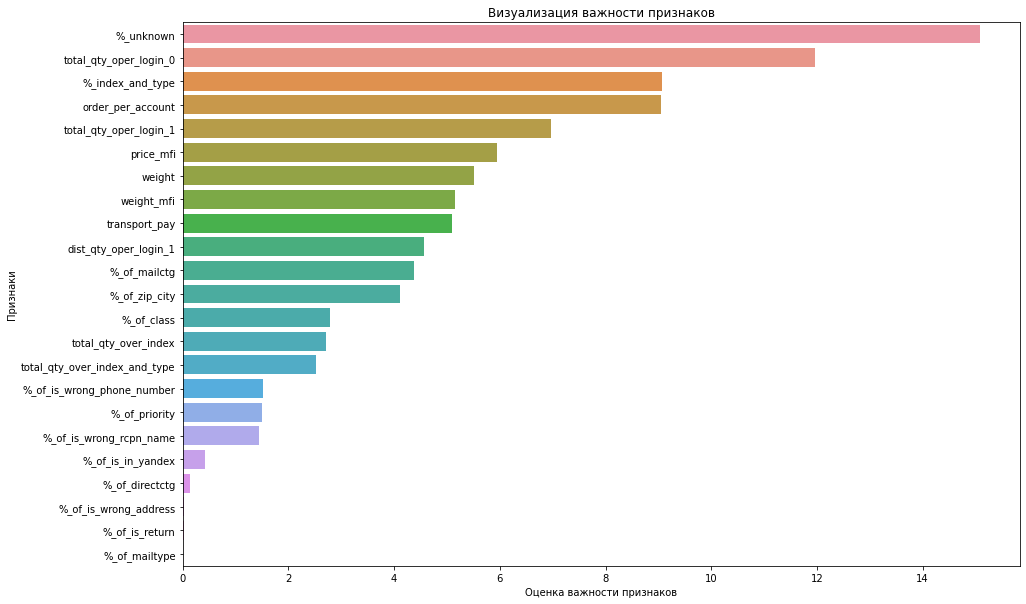

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(15, 10))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')
    print(feature_imp.head(50))#


![image.png](attachment:image.png)
chart_feature_imp(cat)

## Обработка основной тестовой выборки

In [397]:
df_test = pd.read_csv('test.csv')

C:\Users\EGO\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [398]:
# df_test = df_copy

In [399]:
df_test[df_test['index_oper'] == ' '].count()

id                               101
oper_type + oper_attr            101
index_oper                       101
type                             101
priority                         101
is_privatecategory               101
class                            101
is_in_yandex                     101
is_return                        101
weight                           101
mailtype                         101
mailctg                          101
mailrank                         101
directctg                        101
transport_pay                    101
postmark                         101
name_mfi                         101
weight_mfi                       101
price_mfi                        101
dist_qty_oper_login_1            101
total_qty_oper_login_1           101
total_qty_oper_login_0           101
total_qty_over_index_and_type    101
total_qty_over_index             101
is_wrong_sndr_name               101
is_wrong_rcpn_name               101
is_wrong_phone_number            101
i

In [400]:
df_test.loc[(df_test.index_oper == ' '), 'index_oper'] = 0

In [401]:
df_test['index_oper']=df_test['index_oper'].astype('float') # pandas понимает, что в итоге нужен int64

In [402]:
df_test['index_oper']=df_test['index_oper'].astype('int') # pandas понимает, что в итоге нужен int64

In [403]:
df_test['index_oper']=df_test['index_oper'].astype('str') # pandas понимает, что в итоге нужен int64

In [404]:
def df_test_perc_of(seq, column, x):
    q= seq[column]
    return x['%_of_'+column][q]

In [405]:
df.head()

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
117037,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0.422051,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
1283098,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,1,3.701305,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
3344511,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,0,3.701305,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
4829228,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
958739,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,1,6.051960,9.175427,2.341582,2.848811,2.850904,2.153912,2.855003,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000


In [406]:
for i in cat_cols:
    df_test[i]=df_test[i].astype('str')

In [407]:
df_copy['priority']=df_test['priority'].astype('str')

In [408]:
for i in columns_all:
    x = pd.pivot_table(df_copy, values= '%_of_'+i, 
                               index=i, 
                               aggfunc='mean')

    x = x.to_dict()
    
    df_test['%_of_'+i] = df_test.apply(df_test_perc_of, column = i, x = x, axis=1)

## zip_code

In [409]:
df_test['zip_city'] = df_test.apply(zip_def, my_dict = my_dict, axis = 1)

In [410]:
df_test = df_test.fillna('unknown')

In [411]:
x = pd.pivot_table(df_copy, values= '%_of_zip_city', 
                               index='zip_city', 
                               aggfunc='mean')

x = x.to_dict()
    
df_test['%_of_zip_city'] = df_test.apply(df_test_perc_of, column = 'zip_city', x = x, axis=1)

In [412]:
df_test.head(10)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city,%_of_zip_city
0,7815282,8_13,102976,ММПО,7503.0,N,0.0,N,N,85.0,5.0,1.0,0.0,2.0,0.00,0.0,"Screen Protectors,protective case",73.0,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0,6.767832,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459
1,8443555,8_2,238753,ГОПС,7503.0,N,4.0,Y,N,21.0,5.0,0.0,0.0,2.0,0.00,0.0,String Iron Block,19.0,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,Калининградская область,3.510569
2,6352559,1020_-1,618254,ГОПС,7503.0,N,4.0,Y,N,388.0,5.0,1.0,0.0,2.0,34.01,0.0,Jackets,348.0,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Пермский край,5.617566
3,4921420,1016_-1,102968,ТИ,7503.0,N,0.0,N,N,1203.0,5.0,1.0,0.0,2.0,83.72,0.0,0,0.0,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0,0.000000,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459
4,1420440,1018_-1,102971,Цех,7506.0,N,0.0,N,N,956.0,5.0,1.0,0.0,2.0,14.95,0.0,"Unisex Boots,Boots",946.0,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0,0.096186,2.847376,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459
5,2834924,1019_-1,601802,ГОПС,7503.0,N,4.0,Y,N,199.0,5.0,1.0,0.0,2.0,0.00,0.0,Sandals,198.0,222.0,1.0,4105.0,537.0,4642.0,26348.0,0,1,0,0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Владимирская область,2.338151
6,2746939,1041_-1,102971,Цех,7506.0,N,0.0,N,N,1588.0,5.0,1.0,0.0,2.0,89.35,0.0,MODULE,1427.0,1000.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0.096186,2.847376,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459
7,9472576,8_0,630960,МСЦ,7506.0,N,0.0,N,N,605.0,5.0,1.0,0.0,2.0,0.00,0.0,electronic piggy bank,611.0,1700.0,55.0,9141128.0,3286.0,9144414.0,17526965.0,0,1,0,0,0.015091,2.847376,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Новосибирская область,1.158940
8,695233,1022_-1,628950,Участок,7503.0,N,0.0,Y,N,419.0,5.0,1.0,0.0,2.0,35.16,0.0,shell,168.0,319.0,25.0,673937.0,146947.0,820884.0,5688336.0,0,0,0,0,0.097536,2.850213,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Ханты-Мансийский автономный округ,2.412704
9,909788,1014_-1,102976,ММПО,7503.0,N,0.0,N,N,95.0,5.0,0.0,0.0,2.0,0.00,0.0,shirt,86.0,498.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,1,0,6.767832,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.982038,7.791488,2.835738,Москва,3.498459


In [413]:
df_test.drop(del_col, axis = 1,inplace = True)

In [414]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 24 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   weight                         float64
 1   transport_pay                  float64
 2   weight_mfi                     float64
 3   price_mfi                      float64
 4   dist_qty_oper_login_1          float64
 5   total_qty_oper_login_1         float64
 6   total_qty_oper_login_0         float64
 7   total_qty_over_index_and_type  float64
 8   total_qty_over_index           float64
 9   %_of_type                      float64
 10  %_of_priority                  float64
 11  %_of_is_privatecategory        float64
 12  %_of_class                     float64
 13  %_of_is_in_yandex              float64
 14  %_of_is_return                 float64
 15  %_of_mailtype                  float64
 16  %_of_mailctg                   float64
 17  %_of_directctg                 float64
 18  %_

In [415]:
df_test['%_index_and_type'] = df_test['total_qty_over_index_and_type']*100/df_test['total_qty_over_index']

In [416]:
df_test['%_unknown'] = df_test['total_qty_oper_login_0'] * 100 / df_test['total_qty_over_index_and_type']

In [417]:
df_test['order_per_account'] = df_test['total_qty_over_index_and_type'] / df_test['dist_qty_oper_login_1']

In [418]:
df_test

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
0,85.0,0.00,73.0,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,6.767832,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,96.945319,56.991463,1.644952e+05
1,21.0,0.00,19.0,186.0,2.0,2895.0,1545.0,4440.0,20623.0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,Калининградская область,3.510569,21.529360,34.797297,2.220000e+03
2,388.0,34.01,348.0,500.0,3.0,2751.0,993.0,3744.0,37817.0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Пермский край,5.617566,9.900309,26.522436,1.248000e+03
3,1203.0,83.72,0.0,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0.000000,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459,99.044274,19.467196,1.687963e+05
4,956.0,14.95,946.0,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0.096186,2.847376,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459,90.532066,0.011487,4.207013e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,53.0,0.00,61.0,262.0,3.0,4297.0,1803.0,6100.0,64613.0,10.529771,2.850213,2.845951,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Республика Хакасия,2.922291,9.440825,29.557377,2.033333e+03
3999996,286.0,32.05,0.0,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,6.767832,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459,96.605599,63.036550,1.446122e+05
3999997,733.0,49.98,662.0,300.0,106.0,17348074.0,3469387.0,20817461.0,20821109.0,0.000000,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Москва,3.498459,99.982479,16.665755,1.963911e+05
3999998,265.0,0.00,247.0,500.0,2.0,15.0,13673720.0,13673735.0,14041298.0,0.097536,2.850213,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,97.382272,99.999890,6.836868e+06


### Удаление дополнительно признаков

#### Delete %_of_type

In [419]:
df_test.drop('%_of_type', axis = 1,inplace = True)

#### Delete %_of_is_privatecategory

In [420]:
df_test.drop('%_of_is_privatecategory', axis = 1,inplace = True)

#### Delete %_of_is_wrong_sndr_name

In [421]:
df_test.drop('%_of_is_wrong_sndr_name', axis = 1,inplace = True)

#### Delete zip_city

In [422]:
df_test.drop('zip_city', axis = 1,inplace = True)

In [423]:
# df_test.to_csv("df_test_test_test.csv", sep = ',', line_terminator='\n', index = False)

In [424]:
# df_test = pd.read_csv('df_test_final.csv')

### Зполнение пропусков и бесконечностей

In [425]:
df_test = df_test.fillna(0)

In [426]:
df_test.replace([np.inf, -np.inf], 0, inplace=True)

In [427]:
df_test.head(5)

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
0,85.0,0.00,73.0,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,2.850213,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.945319,56.991463,164495.157407
1,21.0,0.00,19.0,186.0,2.0,2895.0,1545.0,4440.0,20623.0,2.850213,10.276892,2.341582,2.848811,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.510569,21.529360,34.797297,2220.000000
2,388.0,34.01,348.0,500.0,3.0,2751.0,993.0,3744.0,37817.0,2.850213,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,5.617566,9.900309,26.522436,1248.000000
3,1203.0,83.72,0.0,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,2.850213,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,99.044274,19.467196,168796.260870
4,956.0,14.95,946.0,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,2.847376,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,90.532066,0.011487,420701.303867


In [428]:
# df_test.to_csv("my_test.csv", sep = ',', line_terminator='\n', index = False)

In [429]:
# df_test = pd.read_csv('my_test.csv')

## Предсказание

In [430]:
predict = cat.predict_proba(df_test)[:,1]

In [431]:
new_list = []
for i in list(predict):
    if i > 0.25:
        new_list.append(1)
    else:
        new_list.append(0)

In [432]:
predict = new_list

In [433]:
len(predict)

4000000

In [434]:
predict

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [435]:
submission_ = pd.read_csv('sample_solution.csv')

In [436]:
submission_

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,0
3999996,6275048,0
3999997,4701757,0
3999998,611153,0


In [437]:
submission_['label'] = predict

In [439]:
submission_.to_csv("3.5.csv", sep = ',', line_terminator='\n', index = False)

In [438]:
submission_['label'].value_counts()

0    3279801
1     720199
Name: label, dtype: int64